 # Project Overview

The domain that I will be working on for this capstone project is image captioning, which is a multi modal task involving both image encoding and language generation. Traditionally CNN-RNN combination has been used for similar tasks. Using this project I want to
implement a project based on the latest research which involves using transformers and has produced state of the art results.
I chose this particular project because it will give me exposure to working on transformers,NLP and Image recognition all together.

## Datasets and Input Data

The dataset that I finally used for this project is Flick 8k because of logistical issues I wasnt able to use Flickr30k as that resulted in my AWS limit getting exceeded.

Flickr8k dataset is a standard benchmark database for image description based tasks was used. The dataset can be found from kaggle. The dataset is divided into 2 parts, first is the 8k image set and second is the csv file containing 3 columns,image_name which is the name of the image file, the comment id and the comment.


# Problem Statement

Generating sentence based image descriptions or Captions for images as input.

## Proposed Solution

We apply a deep learning approach to solving this image captioning problem. We will try to use attention based mechanism to encode the image and generate captions using the decoder.

# Downloading the Data

In [3]:
!pip install kaggle
!pip install kaggle-cli

In [7]:
!chmod 600 /home/ec2-user/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d adityajn105/flickr8k

 99%|█████████████████████████████████████▋| 1.03G/1.04G [00:14<00:00, 73.7MB/s]
100%|██████████████████████████████████████| 1.04G/1.04G [00:14<00:00, 74.3MB/s]


# Analysis

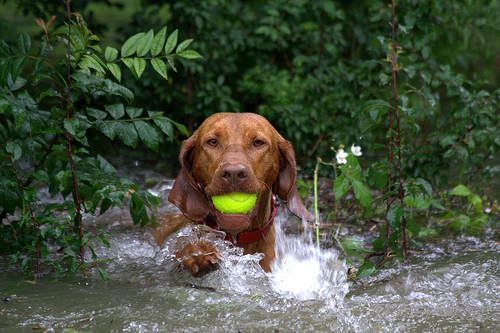

In [11]:
# Data Exploration
from PIL import Image
Image.open('./Images/1130369873_d80a1aa59c.jpg')

The Dataset used for the task is the Flickr8k which is described as

A benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations

The Dataset contains a folder with 8k images and a corresponding txt file with the captions for each image, for every image there are 5 captions on which the model is trained

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


In [2]:
# Load any image and convert it into the format expected by inception v3. Inception v3 is used to extract the features stored in the image,
# it is trained on image net
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [3]:
# Downloading and initialising inception v3(pretrained model) which will be used to extract the features 
# by using all but the last layer of the model
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Preprocess and tokenize the captions

In [3]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [4]:
# Function used to open the captions file and read all the image names and corresponding captions
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')

    # Reading all text and storing it.
    text = file.read()

    # Closing the file
    file.close()
    
    return text

In [5]:
# This function is used to convert the above read text file into a dictionary with the key as the image name and the corresponding value as a 
# list of captions for that image
def photo_to_description_mapping(descriptions):
    
    # Dictionary to store the mapping of photo identifiers to descriptions
    description_mapping = dict()
    
    # Iterating through each line of the descriptions
    for line in descriptions.split('\n'):
        
        # Splitting the lines by white space
        words = line.split()
        
        # Skipping the lines with length less than 2
        if len(line)<2:
            continue
            
        # The first word is the image_id and the rest are the part of the description of that image
        image_id, image_description = words[0], words[1:]
        
        # Retaining only the name of the image and removing the extension from it
        image_id = image_id.split('.')[0]
        
        if image_id == 'image,caption':
            continue
        
        # Image_descriptions contains comma separated words of the description, hence, converting it back to string
        image_description = ' '.join(image_description)
        image_description = '<start> '+image_description+' <end>'
        # There are multiple descriptions per image, 
         # hence, corresponding to every image identifier in the dictionary, there is a list of description
        # if the list does not exist then we need to create it
        
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
            
        # Now storing the descriptions in the mapping
        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [6]:
# This function preprocesses the captions to remove single letter words, numerical words and converts all words to lower case
def clean_descriptions(description_mapping):
    
    # Preapring a translation table for removing all the punctuation
    table = str.maketrans('','', str.punctuation)
    
    # Traversing through the mapping we created
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            # Converting all the words to lower case
            description = [word.lower() for word in description]
            
            # Removing the punctuation using the translation table we made
            description = [word.translate(table) for word in description]
            
            # Removing the words with length =1
            description = [word for word in description if len(word)>1]
            
            # Removing all words with number in them
            description = [word for word in description if word.isalpha()]
            
            # Converting the description back to string and overwriting in the descriptions list
            descriptions[i] = ' '.join(description)
            

In [7]:
# Calling the above functions
filename = './captions.txt'
# Loading descriptions
doc = load_doc(filename)

# Parsing descriptions
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))
# clean_descriptions(descriptions)

Loaded: 8091 


In [8]:
# Get unique images
encode_train = sorted(os.listdir('./Images/'))
encode_train = ['./Images/'+x for x in encode_train]
encode_train = [x for x in encode_train if '.jpg' in x]

In [9]:
len(encode_train), encode_train[0]

(8091, './Images/1000268201_693b08cb0e.jpg')

In [ ]:
# # Extract features using inceptionv3 and save it as numpy files, the shape of the ouput of the last layer is 8 x 8 x 2048
# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(load_image).batch(16)
# for img, path in image_dataset:
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         # print(path_of_feature.split('/')[-1].split('.')[0])
#         path_of_feature = './Images_numpy/'+path_of_feature.split('/')[-1].split('.')[0]+'.npy'

#         np.save(path_of_feature, bf.numpy())

In [10]:
train_image_paths = [x.split('/')[-1].split('.')[0] for x in encode_train]

In [11]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    try:
        caption_list = descriptions[image_path]  
        train_captions.extend(caption_list)
        img_name_vector.extend([image_path] * len(caption_list))
    except:
        print(image_path)

In [9]:
# Tokenize the captions and save the tokenizer

In [41]:
# # Choose the top 5000 words from the vocabulary
# top_k = 5000
# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
#                                                   oov_token="<unk>",
#                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# tokenizer.fit_on_texts(train_captions)

In [42]:
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'

In [ ]:
# with open('./tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
with open('./model-data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [18]:
# Split the data into training and validation
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])


In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

In [ ]:
# # Save the train and validation files
# with open('/gdrive/MyDrive/Flickr8k/train_data/img_name_train_file', 'wb') as fp:
#     pickle.dump(img_name_train , fp)
# with open('/gdrive/MyDrive/Flickr8k/train_data/cap_train_file', 'wb') as fp:
#     pickle.dump(cap_train , fp)
# with open('/gdrive/MyDrive/Flickr8k/train_data/img_name_val_file', 'wb') as fp:
#     pickle.dump(img_name_val , fp)
# with open('/gdrive/MyDrive/Flickr8k/train_data/cap_val_file', 'wb') as fp:
#     pickle.dump(cap_val , fp)

# Model Training

In [3]:
with open('./model-data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [4]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [5]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
loss_plot = []


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# @tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([3] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [6]:
def map_func(img_name, cap):
    path = str(img_name.decode('utf-8'))+'.npy'
#     path = path.split('.')
#     path = '.'+path[1]+'.npy'
#     path = path.split('/')[2]
    data_dir = '/gdrive/MyDrive/Flickr8k'
    data_path = os.path.join(data_dir,'Images_numpy')
    new_path = os.path.join(data_path,path)
#     print(new_path)
    # if(len(cap)!=80):
    #   print(len(cap))
    img_tensor = np.load(new_path)
    return img_tensor, cap
    

In [7]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [14]:
with open('./train_data/img_name_train_file', 'rb') as fp:
    img_name_train = pickle.load(fp)
with open('./train_data/cap_train_file', 'rb') as fp:
    cap_train = pickle.load(fp)
with open('./train_data/img_name_val_file', 'rb') as fp:
    img_name_val = pickle.load(fp)
with open('./train_data/cap_val_file', 'rb') as fp:
    cap_val = pickle.load(fp)


In [9]:
max_length = 28
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [10]:
# Training Prashant
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
print(img_name_train[0])
print(cap_train[0])
# Use map to load the numpy files in parallel

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]))
# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=BUFFER_SIZE)

#     checkpoint_path = args.model_dir
vocab_size = 5000
num_steps = len(img_name_train)
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
encoder.load_weights('./model-data/encoder/')
decoder.load_weights('./model-data/decoder/')

191003285_edd8d0cf58
[   2   12    9    4   19  167    7    6  169    9 1050    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
# print(img_name_train[0])
# print(cap_train[0])
# # Use map to load the numpy files in parallel

# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int32]))
# # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=BUFFER_SIZE)

# #     checkpoint_path = args.model_dir
# vocab_size = 5000
# num_steps = len(img_name_train)

# encoder = CNN_Encoder(embedding_dim)
# decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

encoder_path = './model-data/encoder/'
decoder_path = './model-data/decoder/'

# encoder1.load_weights(encoder_path)
# decoder1.load_weights(decoder_path)

start_epoch = 0

EPOCHS = 7

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    img = './Images/3767841911_6678052eb6.jpg'
    result, attention_plot = evaluate(img)

    print ('Prediction Caption:', ' '.join(result[:-1]))


    # ckpt_manager.save()
    for (batch, (img_tensor, target)) in enumerate(dataset):
        # print(img_tensor)
        
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    # img = '/gdrive/MyDrive/Flickr8k/3767841911_6678052eb6.jpg'
    result, attention_plot = evaluate(img)

    # print ('Real Caption:', real_caption)
    print ('Prediction Caption:', ' '.join(result[:-1]))
    
    encoder.save_weights(encoder_path)
    decoder.save_weights(decoder_path)

print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                    total_loss / num_steps))
print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Model Evaluation

In [2]:
# If ran the above one(import cell) no need to run this
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle



In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


87916544/87910968 [==============================] - 1s 0us/step


In [4]:
# image_features_extract_model.save('./model-data/image_features_extract_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model-data/image_features_extract_model/assets


In [21]:
image_features_extract_model = tf.keras.models.load_model('./model-data/image_features_extract_model')

In [5]:
with open('./model-data/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [22]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
loss_plot = []


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

# @tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([3] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [23]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [24]:
max_length = 28
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, 5000)
encoder.load_weights('./model-data/encoder/')
decoder.load_weights('./model-data/decoder/')

In [37]:
total*5/count

0.1825403877240606

In [35]:
from nltk.translate.bleu_score import sentence_bleu
total = 0
count = 1
score_max =0
for img_name in img_name_val[:500]:
    img = './Images/'+img_name+'.jpg'
    # rid = np.random.randint(0, len(img_name_val))
    # image = img_name_val[rid]
    # real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(img)
    candidate = result[:-1]
    counter =0
    while(len(result)<=3 and counter<=10):
        result, attention_plot = evaluate(img)
        candidate = result[:-1]
        counter+=1
    temp_score = 0
    score = 0
    for caption_number in range(5):
        reference = descriptions[img_name][caption_number]
        temp_score = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))
        score = max(temp_score,score)
        
    if((count-1)%5==0):
        total+=score_max
        score_max = score
    else:
        score_max = max(score,score_max)
    print(score_max)
    count = count + 1
#     print(descriptions[img_name])
#     print(result[:-1])
    # print ('Real Caption:', real_caption)
#     print ('Prediction Caption:', ' '.join(result[:-1]))

0.2
0.2
0.2
0.2
0.2
0
0
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.16666666666666669
0.16666666666666669
0.2
0.2
0.2
0
0.25
0.25
0.25
0.25
0
0.14285714285714285
0.14285714285714285
0.25
0.25
0.047619047619047616
0.05000000000000001
0.07142857142857141
0.25
0.25
0.16666666666666669
0.16666666666666669
0.16666666666666669
0.16666666666666669
0.16666666666666669
0
0.047619047619047616
0.16666666666666669
0.16666666666666669
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.3333333333333333
0
0
0
0
0
0
0
0
0
0
0.037037037037037035
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.25
0.25
0.25
0.25
0.25
0.12500000000000003
0.14285714285714285
0.14285714285714285
0.14285714285714285
0.14285714285714285
0
0.2
0.3333333333333333
0.3333333333333333
0.3333333333333333
0.11111111111111109
0.14285714285714285
0.25
0.25
0.25
0
0
0.07692307692307693
0.07692307692307693
0.07692307692307693
0.2
0.2
0.3333333

In [63]:
img = './Images/1130369873_d80a1aa59c.jpg'
# rid = np.random.randint(0, len(img_name_val))
# image = img_name_val[rid]
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(img)

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result[:-1]))

Prediction Caption: away from water carrying a red collar fetching a red collar


In [28]:
# Srving model tensorflow

In [1]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [2]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [31]:
prefix = 'model'
data_dir = 'model-data'
# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-030119708563/model


In [32]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [33]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    return img_tensor_val
#     print(predictor.predict(img_tensor_val))

In [36]:
img = './Images/1130369873_d80a1aa59c.jpg'
res = evaluate(img)

In [37]:
type(res)

tensorflow.python.framework.ops.EagerTensor

In [8]:
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket()+'/model',
                                  role = role,
                                  framework_version = '2.0',
                                  entry_point = 'predict.py')

In [9]:
%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                          instance_type='ml.m5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (404) when calling the HeadObject operation: Not Found